In [54]:
from hoboreader import HoboReader

In [55]:
h=HoboReader('sample_hobo_data.csv')

In [56]:
g=h.get_rdf()

### Get sensor uri

In [57]:
q="""
SELECT * 
WHERE 
    { 
        ?s a sosa:Sensor . 
    }
"""
sensor_uri=list(g.query(q))[0][0]
sensor_uri

rdflib.term.URIRef('http:www.example.org/my_sensor')

### Get property labels

In [58]:
q="""
SELECT ?label 
WHERE 
    { 
        ?property a ssn:Property . 
        ?property rdfs:label ?label
    }
"""
property_labels=list(g.query(q))
property_labels

[(rdflib.term.Literal('Coupler Detached')),
 (rdflib.term.Literal('Coupler Attached')),
 (rdflib.term.Literal('Temp')),
 (rdflib.term.Literal('End Of File')),
 (rdflib.term.Literal('Host Connected')),
 (rdflib.term.Literal('Serial number')),
 (rdflib.term.Literal('Model')),
 (rdflib.term.Literal('Manufacturer')),
 (rdflib.term.Literal('Stopped'))]

### Get temperature data

In [61]:
from datetime import datetime
q="""
SELECT ?datetime ?value ?unit 
WHERE
    {
        ?property rdfs:label 'Temp' . 
        ?observation sosa:observedProperty ?property ;
            sosa:hasResult ?result ;
            sosa:resultTime ?time .
        ?time time:inXSDDateTimeStamp ?datetime .
        ?result qudt:numericValue ?value ;
            qudt:unit ?unit .
    }
ORDER BY ?datetime
"""
result=g.query(q)
vars=[str(x) for x in result.vars]
temp_data=[(datetime.fromisoformat(str(x[0])),x[1].value,x[2]) for x in result]

In [62]:
import pandas as pd
df=pd.DataFrame(columns=vars,data=temp_data)
df

,datetime,value,unit
0,2019-10-10 11:00:00+01:00,72.199,http://qudt.org/vocab/unit/DEG_F
1,2019-10-10 11:05:00+01:00,72.545,http://qudt.org/vocab/unit/DEG_F
2,2019-10-10 11:10:00+01:00,72.372,http://qudt.org/vocab/unit/DEG_F
3,2019-10-10 11:15:00+01:00,72.545,http://qudt.org/vocab/unit/DEG_F
4,2019-10-10 11:20:00+01:00,72.545,http://qudt.org/vocab/unit/DEG_F
5,2019-10-10 11:25:00+01:00,72.028,http://qudt.org/vocab/unit/DEG_F
6,2019-10-10 11:30:00+01:00,70.480,http://qudt.org/vocab/unit/DEG_F
7,2019-10-10 11:35:00+01:00,69.793,http://qudt.org/vocab/unit/DEG_F
8,2019-10-10 11:40:00+01:00,69.449,http://qudt.org/vocab/unit/DEG_F
9,2019-10-10 11:45:00+01:00,69.278,http://qudt.org/vocab/unit/DEG_F


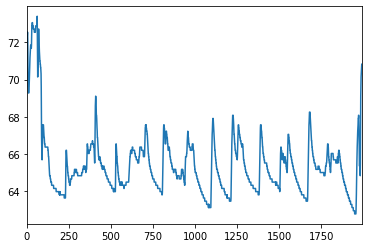

In [63]:
%matplotlib inline
df['value'].plot()